# Exercises week 1

In the first cells we define the needed python functions returning the gradient and the actual function f(x,y) itself.

Next, we take the previously defined functions from the notebook suggested (gd, rms_prop, adam..)

In [107]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import time
from tqdm.notebook import tqdm
from mpl_toolkits.mplot3d import Axes3D
%matplotlib notebook

In [2]:
def func(X, b = 20, q = 0.1, w = 10):
    return b*(1-np.exp(-0.5*w*(X[0]**2+X[1]**2))) + 0.5*q*(-X[0]**3 + X[1])**2

def gradx(X, b = 20, q = 0.1, w = 10):
    return b*np.exp(-0.5*w*(X[0]**2+X[1]**2)) *w*X[0] - 3*q*X[0]**2*(-X[0]**3 + X[1])

def grady(X, b = 20, q = 0.1, w = 10):
    return b*np.exp(-0.5*w*(X[0]**2 + X[1]**2))*w*X[1] + q*(-X[0]**3 + X[1])

def grad(X):
    return [gradx(X), grady(X)]

In [3]:
print(func([0.2,0.2]))

6.595442279287216


<IPython.core.display.Javascript object>


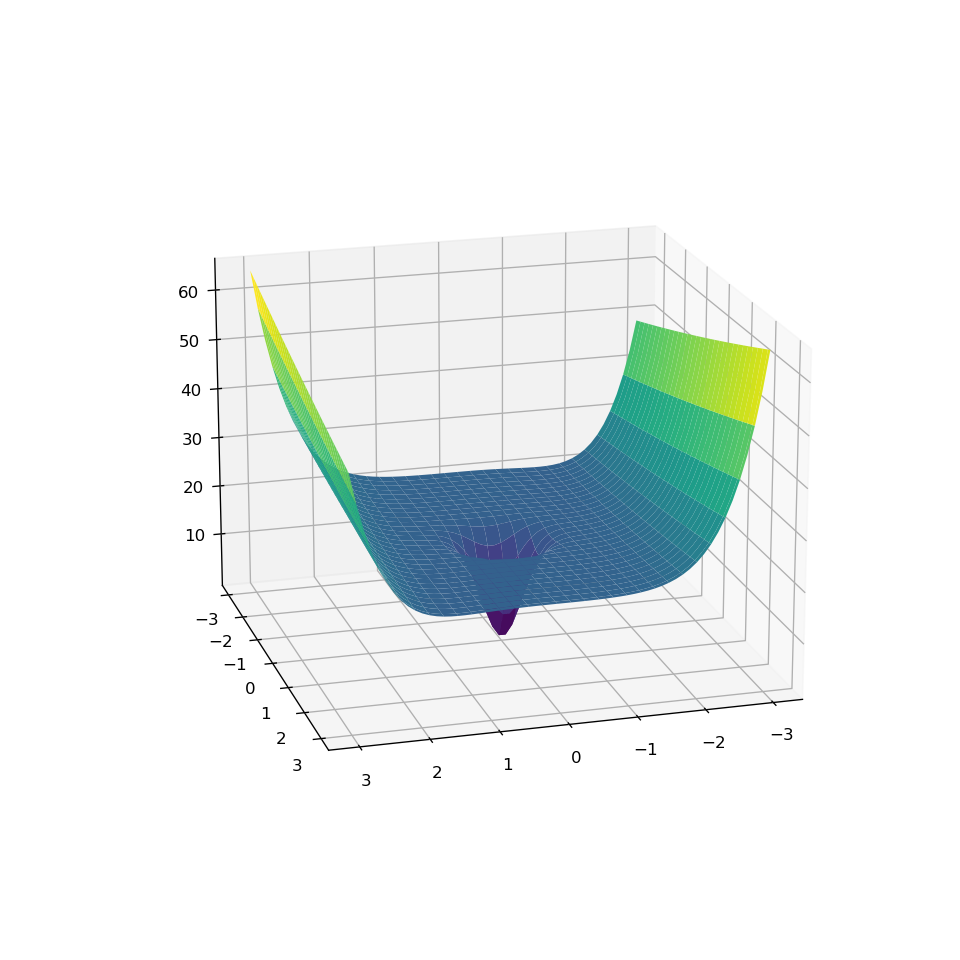

In [116]:
%matplotlib notebook
xplot = np.linspace(-3, 3, 60)
yplot = np.linspace(-3, 3, 60)


Xplot = np.meshgrid(xplot,yplot)
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(projection = '3d')


ax.plot_surface(Xplot[0], Xplot[1], func(Xplot), cmap = 'viridis')
ax.view_init(30,60)
plt.show()


In [117]:
%matplotlib inline
x = np.linspace(-3, 3, 15)
y = np.linspace(-3, 3, 15)


X = np.meshgrid(x,y)

In [14]:
# Vanilla GD
def gd(grad, init, n_epochs=1000, eta=10**-4, noise_strength=0, timing=False):
    start = time.time()
    #This is a simple optimizer
    params=np.array(init)
    param_traj=np.zeros([n_epochs+1,3])
    param_traj[0,]=[init[0], init[1], 0]
    v=0
    for j in range(n_epochs):
        noise=noise_strength*np.random.randn(params.size)
        v=eta*(np.array(grad(params))+noise)
        params=params-v
        param_traj[j+1,]=[params[0], params[1], time.time()-start]
    if timing == False:
        return param_traj[:,:2]
    return param_traj

# Momentum GD
def gd_with_mom(grad, init, n_epochs=5000, eta=10**-4, gamma=0.9,noise_strength=0):
    params=np.array(init)
    param_traj=np.zeros([n_epochs+1,2])
    param_traj[0,]=init
    v=0
    for j in range(n_epochs):
        noise=noise_strength*np.random.randn(params.size)
        v=gamma*v+eta*(np.array(grad(params))+noise)
        params=params-v
        param_traj[j+1,]=params
    return param_traj

# NAG
def NAG(grad, init, n_epochs=5000, eta=10**-4, gamma=0.9,noise_strength=0):
    params=np.array(init)
    param_traj=np.zeros([n_epochs+1,2])
    param_traj[0,]=init
    v=0
    for j in range(n_epochs):
        noise=noise_strength*np.random.randn(params.size)
        params_nesterov=params-gamma*v
        v=gamma*v+eta*(np.array(grad(params_nesterov))+noise)
        params=params-v
        param_traj[j+1,]=params
    return param_traj

#RMS_PROP
def rms_prop(grad, init, n_epochs=5000, eta=10**-3, beta=0.9,epsilon=10**-8,noise_strength=0):
    params=np.array(init)
    param_traj=np.zeros([n_epochs+1,2])
    param_traj[0,]=init#Import relevant packages
    grad_sq=0
    for j in range(n_epochs):
        noise=noise_strength*np.random.randn(params.size)
        g=np.array(grad(params))+noise
        grad_sq=beta*grad_sq+(1-beta)*g*g
        v=eta*np.divide(g,np.sqrt(grad_sq+epsilon))
        params= params-v
        param_traj[j+1,]=params
    return param_traj
                        
#ADAM                       
def adams(grad, init, n_epochs=5000, eta=10**-4, gamma=0.9, beta=0.99,epsilon=10**-8,noise_strength=0):
    params=np.array(init)
    param_traj=np.zeros([n_epochs+1,2])
    param_traj[0,]=init
    v=0
    grad_sq=0
    for j in range(n_epochs):
        noise=noise_strength*np.random.randn(params.size)
        g=np.array(grad(params))+noise
        v=gamma*v+(1-gamma)*g
        grad_sq=beta*grad_sq+(1-beta)*g*g
        v_hat=v/(1-gamma)
        grad_sq_hat=grad_sq/(1-beta)
        params=params-eta*np.divide(v_hat,np.sqrt(grad_sq_hat+epsilon))
        param_traj[j+1,]=params
    return param_traj

We may assume that the iteration time is constant for each step in the process, and simply divide the time needed to finish the function path by the number of epochs to get a single epoch time. 

This approximation is supposed to be always valid, and we checked explicitly it in the GD case.

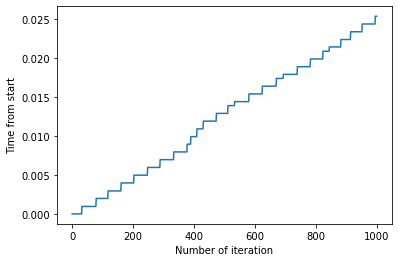

In [114]:
Xf = gd(grad, [-3, 3], timing = True) #returning x,y,t for each iteration
#print(Xf)
plt.plot(Xf[:,2])
plt.xlabel("Number of iteration")
plt.ylabel("Time from start")
plt.show()

Here we define a function returning the results for various functions.  Basically a wrapper for the previous minimization approaches.

In [155]:
def minResults(x,y,eta,epochs,minfunc, func, grad):
    Results = pd.DataFrame()
    count = 0
    start = time.time()
    for i in tqdm(x, leave = False):
        count += 1
        #print(count)
        for j in tqdm(y, leave = False): 
            Results[str(i) + " " + str(j)] = func(minfunc(grad, np.array([i,j]), eta = eta, n_epochs = epochs).T)
    end = time.time()
    return Results.mean(axis = 1), (end-start)/epochs

In [26]:
eta = [0.01, 0.001, 0.0001] #we try different learning rates

In [76]:
Results_gd = pd.DataFrame()
for e in eta:
    print('Minimize with eta = ' , e)
    Results_gd['eta = ' + str(e)], time_per_iteration = minResults(x, y, e, 2000, gd, func, grad)
    Results_gd['eta = ' + str(e) + '_time'] = np.arange(2001)*time_per_iteration/225
    

Minimize with eta =  0.01



Minimize with eta =  0.001



Minimize with eta =  0.0001


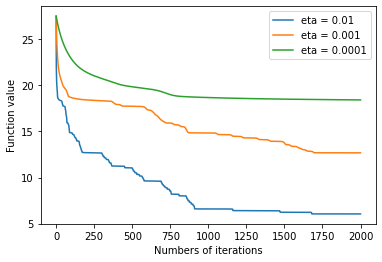

,eta = 0.01,eta = 0.01_time,eta = 0.001,eta = 0.001_time,eta = 0.0001,eta = 0.0001_time
0,27.502115,0.000000,27.502115,0.000000,27.502115,0.000000
1,21.878938,0.000024,26.625108,0.000022,27.410234,0.000023
2,20.861620,0.000047,25.908191,0.000045,27.320239,0.000046
3,20.432680,0.000071,25.308371,0.000067,27.232068,0.000069
4,20.124813,0.000094,24.797286,0.000090,27.145663,0.000091
...,...,...,...,...,...,...
1996,6.050857,0.047129,12.679893,0.044739,18.422489,0.045622
1997,6.050856,0.047153,12.679874,0.044762,18.422362,0.045645
1998,6.050855,0.047176,12.679855,0.044784,18.422236,0.045668
1999,6.050855,0.047200,12.679836,0.044806,18.422109,0.045691


In [59]:
Results_gd.loc[:, ::2].plot()
plt.xlabel("Numbers of iterations")
plt.ylabel("Function value")
plt.show()
Results_gd

The best $\eta$ selected for this case is $\eta$ = 0.001, as it converges to a smaller value, closer to the actual minimum

In [68]:
Results_gd_mom = pd.DataFrame()
for e in eta:
    print('Minimize with eta = ' , e)
    Results_gd_mom['eta = ' + str(e)], time_per_iteration = minResults(x, y, e, 2000, gd_with_mom, func, grad)
    Results_gd_mom['eta = ' + str(e) + '_time'] = np.arange(2001)*time_per_iteration/225

Minimize with eta =  0.01



Minimize with eta =  0.001



Minimize with eta =  0.0001


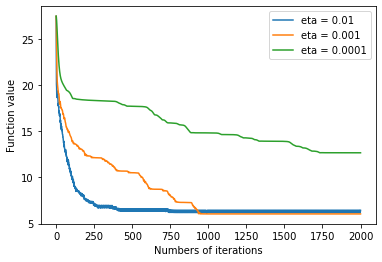

,eta = 0.01,eta = 0.01_time,eta = 0.001,eta = 0.001_time,eta = 0.0001,eta = 0.0001_time
0,27.502115,0.000000,27.502115,0.000000,27.502115,0.000000
1,21.878938,0.000023,26.625108,0.000023,27.410234,0.000025
2,20.098683,0.000046,25.258590,0.000046,27.239199,0.000049
3,19.778421,0.000068,23.810764,0.000069,27.003095,0.000074
4,18.821599,0.000091,22.544892,0.000092,26.716274,0.000098
...,...,...,...,...,...,...
1996,6.319099,0.045574,6.044443,0.045858,12.680029,0.049057
1997,6.426489,0.045597,6.044443,0.045881,12.680010,0.049081
1998,6.200606,0.045620,6.044443,0.045904,12.679991,0.049106
1999,6.319098,0.045643,6.044443,0.045927,12.679973,0.049130


In [65]:
Results_gd_mom.loc[:, ::2].plot()
plt.xlabel("Numbers of iterations")
plt.ylabel("Function value")
plt.show()
Results_gd_mom

In [69]:
Results_NAG = pd.DataFrame()
for e in eta:
    print('Minimize with eta = ' , e)
    Results_NAG['eta = ' + str(e)], time_per_iteration = minResults(x, y, e, 2000, NAG, func, grad)
    Results_NAG['eta = ' + str(e) + '_time'] = np.arange(2001)*time_per_iteration/225

Minimize with eta =  0.01



Minimize with eta =  0.001



Minimize with eta =  0.0001


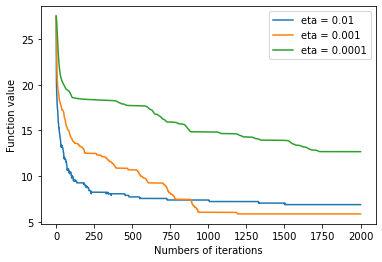

In [72]:
Results_NAG.loc[:, ::2].plot()
plt.xlabel("Numbers of iterations")
plt.ylabel("Function value")
plt.show()
Results_NAG

In [70]:
Results_rms = pd.DataFrame()
for e in eta:
    print('Minimize with eta = ' , e)
    Results_rms['eta = ' + str(e)], time_per_iteration = minResults(x, y, e, 2000, rms_prop, func, grad)
    Results_rms['eta = ' + str(e) + '_time'] = np.arange(2001)*time_per_iteration/225

Minimize with eta =  0.01



Minimize with eta =  0.001



Minimize with eta =  0.0001


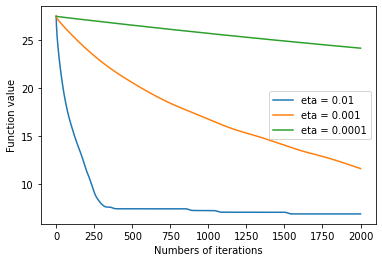

,eta = 0.01,eta = 0.01_time,eta = 0.001,eta = 0.001_time,eta = 0.0001,eta = 0.0001_time
0,27.502115,0.000000,27.502115,0.000000,27.502115,0.000000
1,26.916287,0.000029,27.442277,0.000028,27.496119,0.000026
2,26.514922,0.000057,27.399127,0.000056,27.491771,0.000051
3,26.191423,0.000086,27.363155,0.000083,27.488132,0.000077
4,25.912158,0.000115,27.331336,0.000111,27.484903,0.000102
...,...,...,...,...,...,...
1996,6.936439,0.057264,11.675928,0.055429,24.185304,0.051061
1997,6.936439,0.057293,11.670619,0.055457,24.183863,0.051086
1998,6.936439,0.057322,11.665312,0.055485,24.182422,0.051112
1999,6.936439,0.057350,11.660007,0.055512,24.180980,0.051137


In [73]:
Results_rms.loc[:, ::2].plot()
plt.xlabel("Numbers of iterations")
plt.ylabel("Function value")
plt.show()
Results_rms

In [118]:
Results_adams = pd.DataFrame()
for e in eta:
    print('Minimize with eta = ' , e)
    Results_adams['eta = ' + str(e)], time_per_iteration = minResults(x, y, e, 2000, adams, func, grad)
    Results_adams['eta = ' + str(e) + '_time'] = np.arange(2001)*time_per_iteration/225

Minimize with eta =  0.01



Minimize with eta =  0.001


KeyboardInterrupt: 

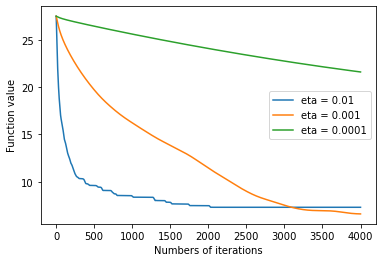

,eta = 0.01,eta = 0.01_time,eta = 0.001,eta = 0.001_time,eta = 0.0001,eta = 0.0001_time
0,27.502115,0.000000,27.502115,0.000000,27.502115,0.000000
1,27.313857,0.000034,27.483162,0.000037,27.500219,0.000036
2,27.064586,0.000068,27.457679,0.000074,27.497665,0.000071
3,26.779890,0.000102,27.427993,0.000110,27.494684,0.000107
4,26.473818,0.000136,27.395369,0.000147,27.491400,0.000142
...,...,...,...,...,...,...
3996,7.288897,0.135748,6.588085,0.147150,21.610497,0.141989
3997,7.288898,0.135782,6.587878,0.147187,21.609439,0.142025
3998,7.288899,0.135815,6.587674,0.147224,21.608382,0.142061
3999,7.288899,0.135849,6.587474,0.147261,21.607325,0.142096


In [83]:
Results_adams.loc[:, ::2].plot()
plt.xlabel("Numbers of iterations")
plt.ylabel("Function value")
plt.show()
Results_adams

The best $\eta$ for every algotithm are choosen as the ones reaching a fast and stable convergence: 

GD: 0.01

GD_mom: 0.001

NAG: 0.001

RMS_PROP: 0.01

ADAM: 0.01

Now we plot the best results for every algorithm with the actual CPU time used.

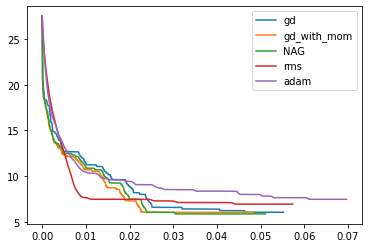

In [87]:
plt.plot(Results_gd["eta = 0.01_time"], Results_gd["eta = 0.01"], label = "gd")
plt.plot(Results_gd_mom["eta = 0.001_time"], Results_gd_mom["eta = 0.001"], label = "gd_with_mom")
plt.plot(Results_NAG["eta = 0.001_time"], Results_NAG["eta = 0.001"], label = "NAG")
plt.plot(Results_rms["eta = 0.01_time"], Results_rms["eta = 0.01"], label = "rms")
plt.plot(Results_adams["eta = 0.01_time"], Results_adams["eta = 0.01"], label = "adam")

plt.legend()
plt.show()

The different minimization algorithms show a similar behaviour when considered over multiple initial points. 

Moreover, the rms one reaches more often a local minimum, and has a medium value typically higher than the other ones. 


On the other hand, the adam algorithm seems not to converge in only 2000 iterations.

In [121]:
def func_2(X, q = 6):
    return 1 + 0.5*q* (X[0]**2+X[1]**2) - np.cos(2*np.pi*(X[0]*X[1]-X[1]**2))

def gradx_2(X,q = 6):
    return q*X[0] + 2*np.pi*X[1]*np.sin(2*np.pi*(X[0]*X[1]-X[1]**2))

def grady_2(X, q = 0.1):
    return q*X[1]+ 2*np.pi*(X[0]-2*X[1])*np.sin(2*np.pi*(X[0]*X[1]-X[1]**2))

def grad_2(X):
    return [gradx_2(X), grady_2(X)]



<IPython.core.display.Javascript object>


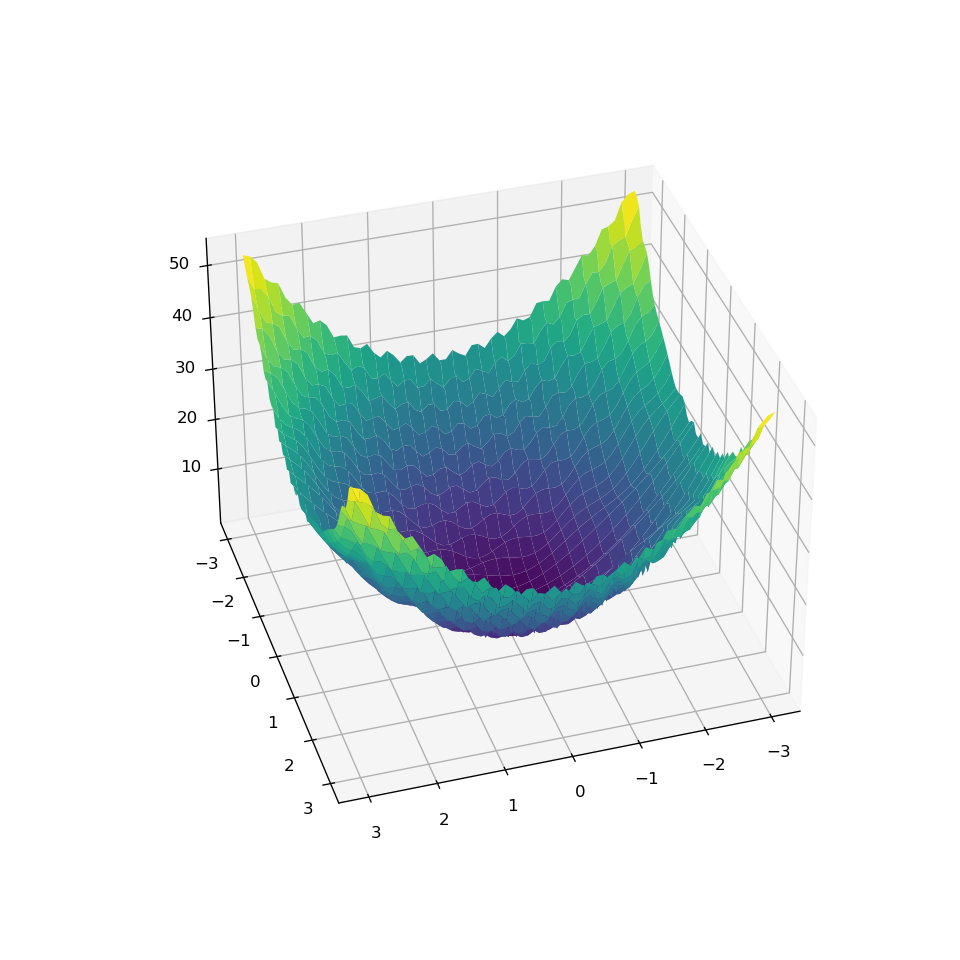

In [122]:
%matplotlib notebook
xplot = np.linspace(-3, 3, 60)
yplot = np.linspace(-3, 3, 60)


Xplot = np.meshgrid(xplot,yplot)
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(projection = '3d')


ax.plot_surface(Xplot[0], Xplot[1], func_2(Xplot), cmap = 'viridis')
ax.view_init(30,60)
plt.show()

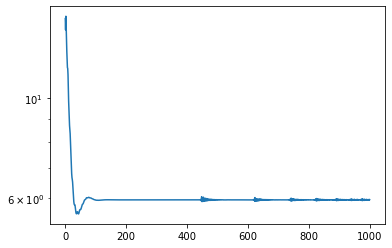

Minimize with eta =  0.01


Minimize with eta =  0.001


Minimize with eta =  0.0001


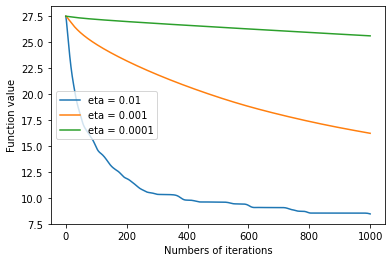

,eta = 0.01,eta = 0.01_time,eta = 0.001,eta = 0.001_time,eta = 0.0001,eta = 0.0001_time
0,27.502115,0.000000,27.502115,0.000000,27.502115,0.000000
1,27.313857,0.000042,27.483162,0.000047,27.500219,0.000046
2,27.064586,0.000083,27.457679,0.000095,27.497665,0.000091
3,26.779890,0.000125,27.427993,0.000142,27.494684,0.000137
4,26.473818,0.000167,27.395369,0.000189,27.491400,0.000182
...,...,...,...,...,...,...
996,8.484661,0.041536,16.242608,0.047098,25.619088,0.045399
997,8.477198,0.041578,16.237364,0.047145,25.617467,0.045445
998,8.469231,0.041619,16.232122,0.047192,25.615846,0.045490
999,8.460867,0.041661,16.226882,0.047239,25.614226,0.045536


In [159]:
%matplotlib inline
OneAdam = adams(grad_2, np.array([1,2]), n_epochs = 1000,eta = 0.05)
plt.plot(np.arange(1001), func_2(OneAdam.T), )
plt.yscale("log")
plt.show()

x = np.linspace(-3, 3, 15)
y = np.linspace(-3, 3, 15)


X = np.meshgrid(x,y)
Results_adams_2 = pd.DataFrame()
for e in eta:
    print('Minimize with eta = ' , e)
    Results_adams_2['eta = ' + str(e)], time_per_iteration = minResults(x, y, e, 1000, adams, func, grad)
    Results_adams_2['eta = ' + str(e) + '_time'] = np.arange(1001)*time_per_iteration/225
    
Results_adams_2.loc[:, ::2].plot()
plt.xlabel("Numbers of iterations")
plt.ylabel("Function value")
plt.show()
Results_adams_2

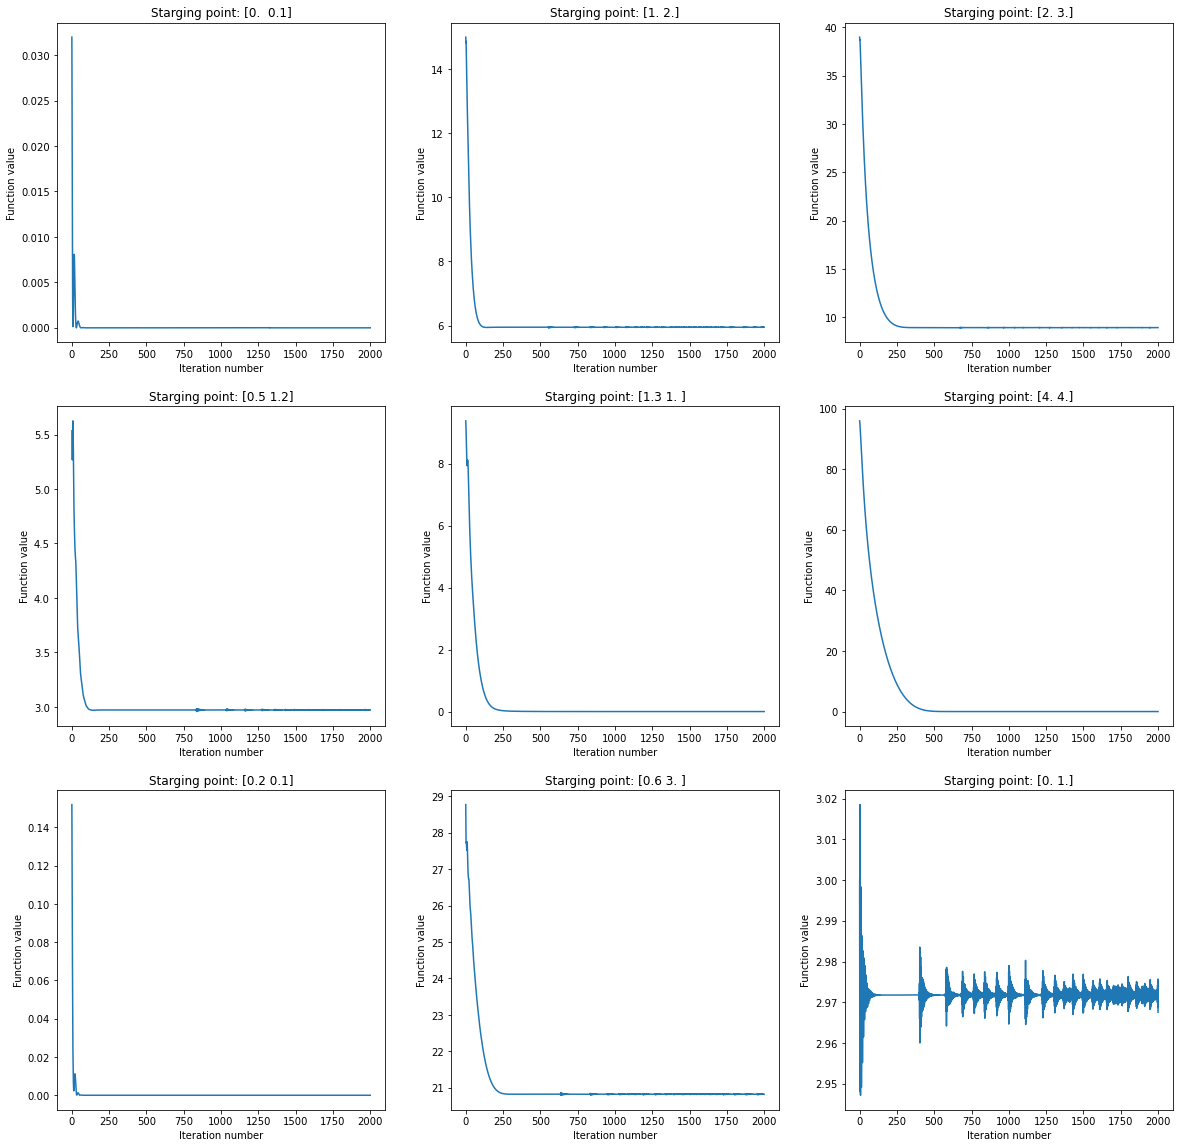

In [183]:
fig, ax = plt.subplots(3,3, figsize = (20,20))

pts_array = np.array([[0.,0.1], [1,2], [2,3], [0.5,1.2], [1.3, 1], [4,4], [0.2, 0.1], [0.6, 3], [0,1]])
epochs = 2000
for i in range(3):
    for j in range(3):
        
        ax[i,j].plot(np.arange(epochs+1), func_2( adams(grad_2, pts_array[3*i+j], n_epochs = epochs,eta = 0.01).T) )
        ax[i,j].set_title("Starging point: "+ str( pts_array[3*i+j]))
        ax[i,j].set_xlabel("Iteration number")
        ax[i,j].set_ylabel("Function value")

plt.show()

As shown in the previous cases, the ADAM algorithm does not manage to converge in all cases. 
In the last one, in particular, it keeps bouncing between some points into the same local minima. 
Clearly this algorithm, for the second function tried, is not sufficiently stable to be relied on.

<IPython.core.display.Javascript object>


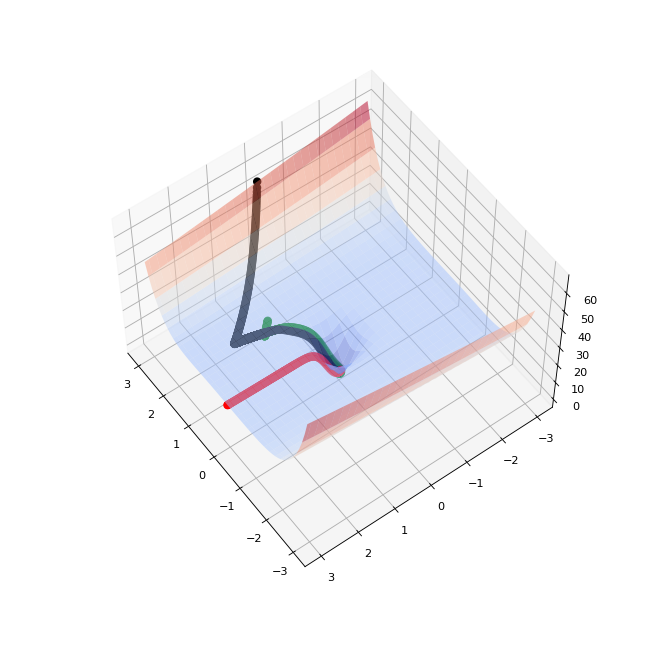

[[ 1.30000000e+00  1.00000000e+00]
 [ 1.29000000e+00  1.01000000e+00]
 [ 1.27656032e+00  1.02344756e+00]
 ...
 [-5.48877019e-18  6.36757278e-19]
 [ 6.13293122e-18  7.40986005e-18]
 [ 1.33395968e-17  4.87728455e-18]]
[ 1.30000000e+00  1.29000000e+00  1.27656032e+00 ... -5.48877019e-18
  6.13293122e-18  1.33395968e-17]


In [228]:
%matplotlib notebook
xplot = np.linspace(-3, 3, 60)
yplot = np.linspace(-3, 3, 60)


Xplot = np.meshgrid(xplot,yplot)
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(projection = '3d')


ax.plot_surface(Xplot[0], Xplot[1], func(Xplot), cmap = 'coolwarm', alpha = 0.5)
ax.view_init(30,60)
#plt.show()

oneGD = adams(grad, [1.3,1], n_epochs=1000, eta=0.01, noise_strength=0,)
print(oneGD)
print(oneGD[:,0])

ax.scatter(oneGD[:,0], oneGD[:,1], func(oneGD.T), marker = 'o', color = 'green', linewidth = 3)
oneGD_2 = adams(grad, [0,3], n_epochs=1000, eta=0.01, noise_strength=0,)

ax.scatter(oneGD_2[:,0], oneGD_2[:,1], func(oneGD_2.T), marker = 'o', color = 'red', linewidth = 3)
oneGD_3 = rms_prop(grad, [3,0], n_epochs=10000, eta=0.01, noise_strength=0,)

ax.scatter(oneGD_3[:,0], oneGD_3[:,1], func(oneGD_3.T), marker = 'o', color = 'black', linewidth = 3)